1. Загрузите данные за май 2016 года.

2. Проведите фильтрацию: удалите поездки с
* нулевой длительностью
* нулевым количеством пассажиров
* нулевым расстоянием поездки по счётчику
* координатами начала, не попадающими в прямоугольник Нью-Йорка
3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d, с которой вы сталкивались в заданиях четвёртого курса). Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

7. Загрузите ноутбук в форму ниже

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1. Загрузим данные за май 2016 года

In [2]:
df = pd.read_csv('../data/yellow_trip_data/yellow_tripdata_2016-05.csv')

df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

print(df.shape)
df.head()

(11836853, 19)


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


2. Проведем фильтрацию

* удалим поездки с нулевой или отрицательной длительностью

In [3]:
df = df[(df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.seconds > 0]

* удалим поездки с нулевым или отрицательным количеством пассажиров

In [4]:
df = df[df['passenger_count'] > 0]

* удалим поездки с нулевым или отрицательным расстоянием

In [5]:
df = df[df['trip_distance'] > 0]

* удалим поездки с непопадающим началом в прямоугольник Нью-Йорка

In [6]:
df = df[
    (-74.25559 <= df['pickup_longitude']) &
    (df['pickup_longitude'] <= -73.70001) &
    (40.49612 <= df['pickup_latitude']) &
    (df['pickup_latitude'] <= 40.91553)
]

3. Агрегируем данные за май 2016 года по часам и областям

Возьмем регионы

In [7]:
regions = pd.read_csv('regions.csv', sep=';')
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [8]:
longitude_bins = (regions['west'].append(regions['east'])).unique()
latitude_bins = (regions['south'].append(regions['north'])).unique()

Посчитаем номера регионов

In [10]:
new_regions = binned_statistic_2d(
    df['pickup_longitude'],
    df['pickup_latitude'],
    df['pickup_longitude'],
    bins=[longitude_bins, latitude_bins],
    statistic='count',
    expand_binnumbers=True
)

Полученные номера регионов присвоим поездкам

In [11]:
df['region'] = (new_regions.binnumber[0] - 1) * 50 + new_regions.binnumber[1]

Удаляем минуты и секунды из времени начала поездки

In [12]:
df['tpep_pickup_datetime'] = df['tpep_pickup_datetime'].dt.floor('H')

Создадим таблицу регионов и времени по часам. Используем для этого groupby по области и созданной колонке, хранящей час

Агрегируем данные по часам и регионам

In [17]:
time_region = pd.crosstab(df['tpep_pickup_datetime'], df['region'])

# заполняем нулями регионы, в которых нету данных
for i in range(1, 2501):
    if i not in time_region.columns:
        time_region[i] = 0
time_region = time_region[sorted(time_region.columns)]

4. Выведем первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

In [18]:
time_region.head()

region,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


5. Построим график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

In [19]:
for i, region in regions.iterrows():
    if (region['west'] <= -73.9857109) & (-73.9857109 <= region['east']) & (region['south'] <= 40.7485605) & (40.7485605 <= region['north']):
        print(region)

region    1231.000000
west       -73.988912
east       -73.977800
south       40.747766
north       40.756154
Name: 1230, dtype: float64


Здание Empire State Building находится в ячейке 1230

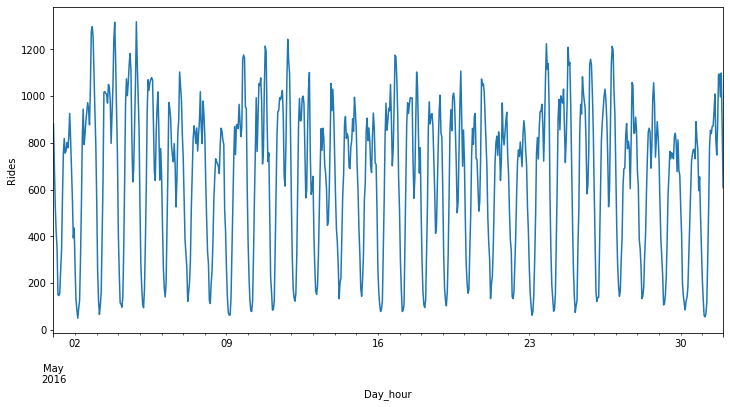

In [26]:
plt.figure(figsize=(12, 6))
time_region[1231].plot()
plt.xlabel('Day_hour')
plt.ylabel('Rides');

6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

Как видно, в большинстве ячеек не было ни одной поездки. Хотя все-таки немало ячеек с поездками

In [27]:
(time_region != 0).sum().sum()

141762

In [28]:
(time_region == 0).values.sum()

1718238

7. Загрузим ноутбук в форму ниже

Загрузили :)